In [1]:
# imports
import math
import numpy as np
import itertools as it
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

# Initialize

In [2]:
# set up demo graph
n = 6
G_A = nx.Graph()
Ef_A = nx.Graph()
P_A = nx.complete_graph(range(1,n+1))
#
G_A.add_nodes_from(range(1,n+1))
Ef_A.add_nodes_from(range(1,n+1))
print(G_A.nodes)
G_A.add_edges_from(((4,5),(3,2),(4,3),(5,2),(6,4),(1,5),(1,2)))
#e1 = (5,4)
#e2 = (4,5)
#f1 = e1 in P_A.edges()
#f2 = e2 in P_A.edges()
#random = nx.erdos_renyi_graph(n,0.07)
#G_A.add_nodes_from(( node + 1 for node in random.nodes()))
#G_A.add_edges_from(( (edge[0]+1,edge[1]+1) for edge in random.edges()))

#print(G_A.nodes)
#print(G_A.edges)

#P_A.remove_edge(*e)
#f1 = e in P_A.edges()
#print(f1)

#display



[1, 2, 3, 4, 5, 6]


# Algorithm 1: DegreeDiffElim

In [3]:
def DegreeDiffElim(G_A,P_A,kA):
    edges = list(P_A.edges())
    for e in edges:
        if abs(G_A.degree(e[0]) - G_A.degree(e[1])) > kA:
            P_A.remove_edge(*e)
    return P_A

# Algorithm 2: FixedDegElim

In [4]:
def FixedDegElim(G_A,P_A,Ef_A):
    edges = list(P_A.edges())
    for e in edges:
        if Ef_A.degree(e[0]) > G_A.degree(e[1]):
            P_A.remove_edge(*e)
    return P_A

# Algorithm 3: Helper Functions

In [5]:
def print_independence(v,i,j,G_A):
    edge,Ni,Nj = pair2neighborhood(G_A,1,2)
    _i = edge[0]
    _j = edge[1]
    print(Ni)
    print(f"Neighborhood of {_i} is {Ni}")
    for _ni in nx.neighbors(G_A,_i):
        print(_ni)
    print(f"Neighborhood of {_j} is {Nj}")
    for _nj in nx.neighbors(G_A,_j):
        print(_nj)
    print("------")
    niUnj = Ni | Nj
    for _e in niUnj:print(_e)

    print(f"Ni union Nj: {niUnj}")
    Nv = set(nx.neighbors(G_A,v))
    print(f"Neighborhood of v: {Nv}")
    _intersection = niUnj.intersection(Nv) 
    print(f"Intersection of Nv and Ni U Nj: {_intersection}")
    print(_intersection)

In [6]:
# check independence 
#
def vertex_independent_from(v,i,j,G_A):
    edge,Ni,Nj = pair2neighborhood(G_A,i,j)
    _i = edge[0]
    _j = edge[1]
    #print(Ni)
    #print(f"Neighborhood of {_i} is {Ni}")
    #for _ni in nx.neighbors(G_A,_i):
        #print(_ni)
    #print(f"Neighborhood of {_j} is {Nj}")
    #for _nj in nx.neighbors(G_A,_j):
        #print(_nj)

    #print("------")
    niUnj = Ni | Nj
    #for _e in niUnj:print(_e)

    #print(f"Ni union Nj: {niUnj}")
    Nv = set(nx.neighbors(G_A,v))
    #print(f"Neighborhood of v: {Nv}")
    _intersection = niUnj.intersection(Nv) 
    #print(f"Intersection of Nv and Ni U Nj: {_intersection}")
    #print(_intersection)
    return not bool(_intersection)

In [7]:
# larger neighborhood should be Ni (line 6 in DKAS)
# larger neighborhood should be on left
def sortByLength(set1,set2):
    if len(set1) == len(set2):
        return set1, set2
    elif len(set1) > len(set2):
        return set1, set2
    else:
        return set2,set1

In [8]:
# mostly as written in DASG paper
# page 8, lines 10-20
#
#
# cost in terms of 'degrees decremented / half-edges removed'
def assign_weight_k1(e,i,j,G_A,P_A,k_A):
    u = e[0]
    v = e[1]
    # mapping to self has 0 cost
    if u == v:
        return 0
    #print("assigning weight",e)
    
    
    degu = G_A.degree(u)
    degv = G_A.degree(v)
    
    # elif because only one neighborhood is being decremented.
    if u in (i,j):
        degu = max(degu - k_A,0)
    elif v in (i,j):
        degv = max(degv - k_A,0)
    # if mapping being tested coincides with edge. 
    if e == (i,j) or e == (j,i):
        #print(f"edge {e} being weighted is mapping {i},{j} being tested")
        return 0
    
    if (u,v) in P_A.edges() or (v,u) in P_A.edges():
        #print(f"{e} in {P_A.edges()}?")
        #cost tightened here
        if degu > degv and vertex_independent_from(u,i,j,G_A):
            #print(f"{e} satisfies FIRST 1 clause!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            return -2*(degu - degv)
        elif degv > degu and vertex_independent_from(v,i,j,G_A):
            #print(f"{e} satisfies SECOND 2 clause!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            return -2*(degv - degu)
        else:
            #print(f"{e} satisfies THIRD 3 clause")
            return -abs(degu - degv)
    else:
        return -math.inf

In [9]:
# this is for d2v and v2d
def assign_weight_k2(neighbor,dummy_parent,Ef_A):
    edge = (neighbor,dummy_parent)
    if edge in Ef_A.edges():
        return -math.inf
    else: return -2

In [10]:
# returns python set of integers, sorted by length
def pair2neighborhood(g,i,j):
    N_i = set((e for e in nx.neighbors(g,i)))
    N_j = set((f for f in nx.neighbors(g,j)))
    #print("1: neighbors")
    #print(N_i)
    #print(N_j)
    #eliminate_this_logic!!!!!!!!!!!!!!!!
    #try:
    #    N_i.remove(j)
    #    N_j.remove(i)
    #except(ValueError,TypeError,KeyError):
    #    print("")
    Ni,Nj = sortByLength(N_i,N_j)
    if g.degree(i) < g.degree(j):
        _i = j
        _j = i
    else:
        # no exchange
        _i = i
        _j = j
    #print(f"2: remove {i} or {j}")
    #print(Ni)
    #print(Nj)
    #remove duplicates
    #duplicates = Ni.intersection(Nj)
    #for d in duplicates:
    #    Ni.remove(d)
    #    Nj.remove(d)
    #print(f"3: remove duplicates: {duplicates}")
    #print(Ni)
    #print(Nj)
    edge = (_i,_j)
    return edge, Ni,Nj

### Algorithm 3: Build Cost Matrix

In [11]:
# build-cost-matrix using python set
def BuildCostMatrix(i,j,G_A,P_A,Ef_A,k_A):
    _edge, _Ni_int,_Nj_int = pair2neighborhood(G_A,i,j)
# initialize    
    CostMatrix = nx.Graph()
    degDiff = abs(G_A.degree(i) - G_A.degree(j))
    Ni = []
    Nj = []
    xi = []
    xj = []
    _i = _edge[0]
    _j = _edge[1]
    # swap j and i in order to consistently refer to larger set on left
    if G_A.degree(i) < G_A.degree(j):
        _i = j
        _j = i
    else:
        # no exchange
        _i = i
        _j = j
    
    
# make vertices
##
## dummy: used for edge deletion
## parent: used in weight assignment logic
## value: used in updating permutation graph
##
    for e in _Ni_int:
        name = "i" + str(e)
        Ni.append(name)
        CostMatrix.add_node(name,bipartite=0,dummy=False,parent=_i,value=e)
    for f in _Nj_int:
        name = "j" + str(f)
        Nj.append(name)
        CostMatrix.add_node(name,bipartite=1,dummy=False,parent=_j,value=f)
        
    #print(f"vertices for Ni: {Ni}")
    #print(f"vertices for Nj: {Nj}")
    
# # larger set xi goes in right partition of graph as indicated by 'bipartite' parameter
    for xe in range(1,degDiff+k_A):
        name = "xi" + str(xe)
        xi.append(name)
        CostMatrix.add_node(name,bipartite=1,dummy=True,parent=_i,value=_i)
    for xf in range(1,k_A):
        name = "xj" + str(xf)
        xj.append(name)
        CostMatrix.add_node(name,bipartite=0,dummy=True,parent=_j,value=_j)
        
    #print(f"xi: {xi}")
    #print(f"xj: {xj}")
    
# make edges (weights negated)
    value = nx.get_node_attributes(CostMatrix,'value') # used for permutation graph update
    parent = nx.get_node_attributes(CostMatrix,'parent') # used for weight assignment
# # vertex to vertex
    V2V = []
    for e0 in it.product(Ni,Nj):
        _edge0 = (value[e0[0]],value[e0[1]])
        weight = assign_weight_k1(_edge0,i,j,G_A,P_A,k_A)
        #print(f" {_edge0} assigned weight: {weight} ")
            
        #print(f" vertex to vertex (Ni cross Nj): {e0} ;weight: {weight}")
        V2V.append((*e0,weight))
        
# # vertex to dummy
    D2V = []
# # #"draw an edge between vj and xj"
    for e1 in it.product(xj,Nj):
        weight = assign_weight_k2(value[e1[1]],parent[e1[0]],Ef_A)
        #print(f" dummy to vertex (xj cross Nj): {e1} ;weight: {weight}")
        D2V.append((*e1,weight))
    
    V2D = []
# # #"draw an edge between ui and xi"
    for e2 in it.product(Ni,xi):
        weight = assign_weight_k2(value[e2[0]],parent[e2[1]],Ef_A)
        #print(f" vertex to dummy (Ni cross xi): {e2} ;weight: {weight}")
        D2V.append((*e2,weight))

# # dummy to dummy
    D2D = []
    for e3 in it.product(xj,xi):
        #print(f"dummy to dummy {e3}")
        D2D.append((*e3,0))

# add weighted edges
    CostMatrix.add_weighted_edges_from(V2V)
    CostMatrix.add_weighted_edges_from(D2V)
    CostMatrix.add_weighted_edges_from(V2D)
    CostMatrix.add_weighted_edges_from(D2D)
# display
    #l,r = bipartite.sets(CostMatrix)
    #print(f"bipartite.sets left set {l}")
    #print(f"bipartite.sets right set {r}")
    return CostMatrix 

# HungarianSolve: find cost perfect matching

In [12]:
# 
# draw bipartite graph
#
def plot_cost_matrix(CostMatrix):
    l,r = bipartite.sets(CostMatrix)
    pos = dict()
    pos.update( (nn, (1, ii)) for ii, nn in enumerate(l) ) # put nodes from X at x=1
    pos.update( (nn, (2, ii)) for ii, nn in enumerate(r) ) # put nodes from Y at x=2
    nx.draw(CostMatrix, pos=pos,with_labels=True)
    #edge weights
    labels = nx.get_edge_attributes(CostMatrix, "weight")
    nx.draw_networkx_edge_labels(CostMatrix, pos=pos, edge_labels=labels)
    print("edge weights")
    for w in labels:
        print(f"edge: {w} -- weight: {labels[w]}")
    plt.show()
    

In [13]:
# HungarianSolve from page 9 of detect-almost-symmetries
# calculates the sum of the weights in the matching
def HungarianSolve(CostMatrix):
    cost = 0
    deleteEdges = []
    #
    # draw bipartite graph
    #
    #plot_cost_matrix(CostMatrix)
    
    #
    # Solve Cost Perfect Matching problem
    #
    Matching = nx.max_weight_matching(CostMatrix,maxcardinality=True)
    #print(f"is perfect matching: {nx.is_perfect_matching(CostMatrix,Matching)}")
    #print(f"MATCHING: {Matching}")
    
    #
    # cost initialize, and ensure that weight of i - j is 0 in costMatrix
    #
    dummy = nx.get_node_attributes(CostMatrix,"dummy")
    value = nx.get_node_attributes(CostMatrix,"value")
    parent = nx.get_node_attributes(CostMatrix,"parent")
    _re = list(CostMatrix.edges())[0]
    _p1 = parent[_re[0]]
    _v1 = value[_re[0]]
    _p2 = parent[_re[1]]
    _v2 = value[_re[1]]
    #print(f"RANDOM EDGE: {_re}, edge parents: {_p1},{_p2} ")
    #cost = abs(nx.degree(G_A,_v1) - nx.degree(G_A,_v2))
    #
    # for each pair in optimal assignment, extract edges which correspond to edge deletions, and sum the cost. 
    #
    for m in Matching:
        i = m[0]
        j = m[1]
        #
        #
        # 'ui is dummy T/F?' XOR 'j is dummy T/F?'
        #
        # "From the solution we determine when an edge {ui, xi} or {vj, xj}
        # is in the optimal assignment. The former corresponds to the deletion of edge {i, u} in
        # GA, the later to the deletion of edge {j, v}."
        #
        #print("assignment: ",m,CostMatrix[i][j]['weight'])
        if dummy[i] ^ dummy[j]:
            #print(f"encoded edge: {m}")
            #print(f"value dict conversion: value[i] = {value[i]}, value[j] = {value[j]}")
            #
            # update cost, deleteEdges
            # cost multiplied by -1 here.
            deleteEdges.append((value[i],value[j]))
        cost +=-1*CostMatrix[i][j]['weight']
            
    return cost,deleteEdges

# REFINEMENT 1: Refine By Matching

In [14]:
#
def RefineByMatching(G_A,P_A,Ef_A,k_A):
    #
    possibleMappings = {}
    edgeUse = {}
    for e in G_A.edges():
        #print("G_A edges: ",e)
        edgeUse[e] = 0
    EP_A = list(P_A.edges())
    #
    #print("for edge in E(P_A)")
    for edge in EP_A:
        i = edge[0]
        j = edge[1]
        #print(f"*****************  Mapping Test : {i} --> {j}  *****************")
        #print(f"G_A = {G_A.edges()}")
        #print(f"P_A = {P_A.edges()}")
        #print(f"Ef_A = {Ef_A.edges()}")
        #print(f"k_A = {k_A}")
        CostMatrix = BuildCostMatrix(i,j,G_A,P_A,Ef_A,k_A)
        cost,deleteEdges = HungarianSolve(CostMatrix)
        #print(f"cost = {cost}")
        #print(f"deleteEdge = {deleteEdges}")
        if cost > 2*k_A:
            #print(f" **** **** **** Mapping {i} --> {j} proven impossible **** **** **** ")
            P_A.remove_edge(*edge)
        else:
            possibleMappings[edge] = deleteEdges
            for _e in deleteEdges:
                e = tuple(sorted(_e))
                edgeUse[e] = edgeUse[e]+1
    #print(edgeUse)
    #print(f"before: {EP_A}")
    #print(f"after: {P_A.edges()}")
    return possibleMappings

# REFINEMENT 2: "Jim Elim"

In [48]:
#  for all pairs (i,j) solve matching in ij
def _wpg1(G_A,Ef_A,k_A):
    _K = nx.complete_graph(G_A.nodes())
    Rho = nx.Graph()
    Rho.add_nodes_from(G_A.nodes())
    print(Rho.nodes())
    for pair in it.combinations(Rho.nodes(),2):
        i = pair[0]
        j = pair[1]
        CostMatrix = BuildCostMatrix(i,j,G_A,_K,Ef_A,k_A)
        cost,deleteEdges = HungarianSolve(CostMatrix)
        if cost <= 2*k_A:
            Rho.add_edge(i,j,weight = cost)
        else:
            Rho.add_edge(i,j,weight = math.inf)
            Ni = nx.neighbors(Rho,i)
            Nj = nx.neighbors(Rho,j)
            for ee in it.
        
        
    return 0

In [49]:
# initialization
def _wpg_increment_adjacent():
    return 0

In [50]:
# while loop
def _wpg3():
    return 0

In [51]:
def weighted_permutation_graph(G_A,P_A,Ef_A,k_A):
    return 0
    

[1, 2, 3, 4, 5, 6]
1, 2
1, 3
1, 4
1, 5
1, 6
2, 3
2, 4
2, 5
2, 6
3, 4
3, 5
3, 6
4, 5
4, 6
5, 6


0

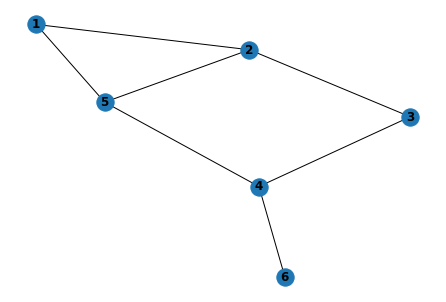

In [52]:
nx.draw(G_A,with_labels=True,font_weight='bold')
k_A = 1
_wpg1(G_A,k_A)

# Driver

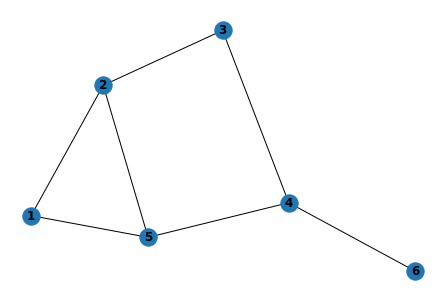

Refine by Matching output below
Refine by Matching output above
 mapping (1, 2) possible when [(2, 3)] is deleted
 mapping (1, 3) possible when [] is deleted
 mapping (1, 5) possible when [(5, 4)] is deleted
 mapping (1, 6) possible when [(1, 2)] is deleted
 mapping (2, 3) possible when [(2, 1)] is deleted
 mapping (2, 4) possible when [] is deleted
 mapping (2, 5) possible when [] is deleted
 mapping (3, 4) possible when [(4, 6)] is deleted
 mapping (3, 5) possible when [(5, 1)] is deleted
 mapping (3, 6) possible when [(3, 2)] is deleted
 mapping (4, 5) possible when [] is deleted


In [20]:
nx.draw(G_A, with_labels=True, font_weight='bold')
plt.show()
#initialize
k_A = 1

b4dde = len(P_A.edges())
b4ddeMat = nx.adjacency_matrix(P_A).todense()
P_A = DegreeDiffElim(G_A,P_A,k_A)
afterdde = len(P_A.edges())
afterddeMat = nx.adjacency_matrix(P_A).todense()
print("Refine by Matching output below")
pm = RefineByMatching(G_A,P_A,Ef_A,k_A)
print("Refine by Matching output above")
#print(f" unproven mappings before DegreeDiffElim: {b4dde} \n")
#print(np.matrix(b4ddeMat))
#print(f"\n unproven mappings after DegreeDiffElim, before RBM: {afterdde} \n")
#print(np.matrix(afterddeMat))
#print(f"\n unproven mappings after RBM:  {len(P_A.edges())}\n")
#print(np.matrix(nx.adjacency_matrix(P_A).todense()))
for _k in pm.keys():
    print(f" mapping {_k} possible when {pm[_k]} is deleted")


#
# draw bipartite graph
#
#l,r = bipartite.sets(cm)
#pos = dict()
#pos.update( (nn, (1, ii+ len(l)/2)) for ii, nn in enumerate(l) ) # put nodes from X at x=1
#pos.update( (nn, (2, n*ii)) for ii, nn in enumerate(r) ) # put nodes from Y at x=2
#nx.draw(cm, pos=pos,with_labels=True)

#edge weights
#labels = nx.get_edge_attributes(cm, "weight")
#nx.draw_networkx_edge_labels(cm, pos=pos, edge_labels=labels)
plt.show()